#### **DO SEMI-SUPERVISED LEARNING**

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
list_dir = os.listdir()

In [2]:
# pre loading all data
generate_file = [file for file in list_dir
                 if file.__contains__('imputed')]
df = pd.DataFrame()
for i,file in enumerate(generate_file):
   temp_df = pd.read_csv(file)
   df = pd.concat([df, temp_df], ignore_index=True)

In [3]:
train_df = df[~df['sii'].isna()]
X_train, X_test, y_train, y_test = \
train_test_split(
    train_df.drop(columns=['sii']),
    train_df['sii'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=train_df['sii']
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC(kernel='rbf', C=1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       319
         1.0       0.95      0.97      0.96       146
         2.0       0.94      0.95      0.94        76
         3.0       1.00      0.57      0.73         7

    accuracy                           0.97       548
   macro avg       0.97      0.87      0.90       548
weighted avg       0.97      0.97      0.97       548

[[315   4   0   0]
 [  2 142   2   0]
 [  0   4  72   0]
 [  0   0   3   4]]


In [4]:
new_sii = df[df['sii'].isna()].drop(columns=['sii'])
new_sii_scaled = scaler.transform(new_sii)
new_sii_pred = model.predict(new_sii_scaled)
new_sii['sii'] = new_sii_pred

In [5]:
df = pd.concat([train_df, new_sii], ignore_index=True)
df.isna().sum()

Basic_Demos-Age                           0
Basic_Demos-Sex                           0
Physical-BMI                              0
IAT-IAT_01                                0
IAT-IAT_02                                0
IAT-IAT_03                                0
IAT-IAT_04                                0
IAT-IAT_05                                0
IAT-IAT_06                                0
IAT-IAT_07                                0
IAT-IAT_08                                0
IAT-IAT_09                                0
IAT-IAT_10                                0
IAT-IAT_11                                0
IAT-IAT_12                                0
IAT-IAT_13                                0
IAT-IAT_14                                0
IAT-IAT_15                                0
IAT-IAT_16                                0
IAT-IAT_17                                0
IAT-IAT_18                                0
IAT-IAT_19                                0
IAT-IAT_20                      

In [6]:
X_train, X_test, y_train, y_test = \
train_test_split(
    df.drop(columns=['sii']),
    df['sii'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df['sii']
)

#### **Train Model with SVM**

In [7]:
param = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

from sklearn.model_selection import GridSearchCV, StratifiedKFold
grid = GridSearchCV(SVC(random_state=RANDOM_SEED, probability=True), param, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED), n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)
print("Best parameters found: ", grid.best_params_)
best_model = grid.best_estimator_
print("Best cross-validation score: {}".format(grid.best_score_))
print("Training set score: {}".format(best_model.score(X_train, y_train)))
print("Test set score: {}".format(best_model.score(X_test, y_test)))

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9880056303158569
Training set score: 0.9965277777777778
Test set score: 0.9962121212121212


In [8]:
model_svm = SVC(**grid.best_params_, random_state=RANDOM_SEED)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)
print('Training Accuracy Score for traditional svm: {}'.format(accuracy_score(y_train, model_svm.predict(X_train))))
print('Testing Accuracy Score for traditional svm: {}'.format(accuracy_score(y_test, y_pred)))

Training Accuracy Score for traditional svm: 0.9965277777777778
Testing Accuracy Score for traditional svm: 0.9962121212121212


In [9]:
# perform adaptive boosting with cross validation
# this is for whether the model is overfitting or not
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
accuracy_score_ada = []
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(estimator=best_model,
                               n_estimators=100, random_state=RANDOM_SEED,
                               learning_rate=0.1)
for train_index, test_index in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    ada_model.fit(X_tr, y_tr)
    score = ada_model.score(X_val, y_val)
    accuracy_score_ada.append(score)

y_ada_pred = ada_model.predict(X_test)
print("Accuracy score: ", np.mean(accuracy_score_ada))


Accuracy score:  0.9857944335742523


In [10]:
# training for the entire train dataset after checking with cross-validation
ada_model = AdaBoostClassifier(estimator=best_model,
                               n_estimators=100, random_state=RANDOM_SEED,
                               learning_rate=0.1)
ada_model.fit(X_train, y_train)
y_ada_pred = ada_model.predict(X_test)
print('training score adaboost: ', ada_model.score(X_train, y_train))
print('test score adaboost: ', ada_model.score(X_test, y_test))

training score adaboost:  0.9921085858585859
test score adaboost:  0.9886363636363636


#### **Model Evaluation**

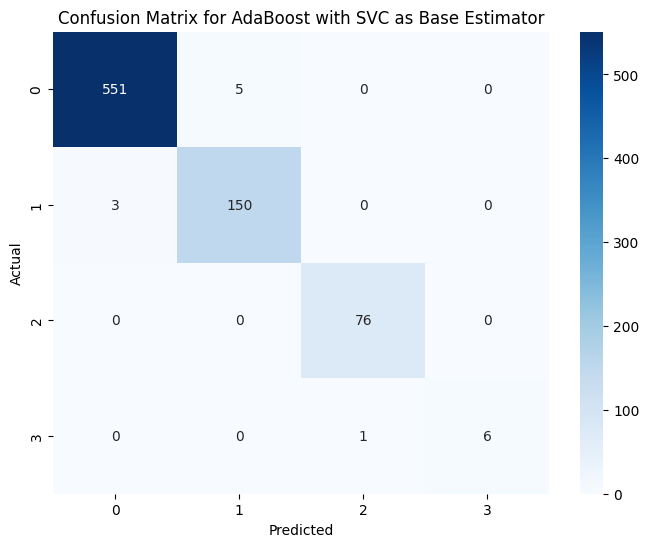

In [11]:
cm_ada = confusion_matrix(y_test, ada_model.predict(X_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm_ada, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost with SVC as Base Estimator')
plt.show()

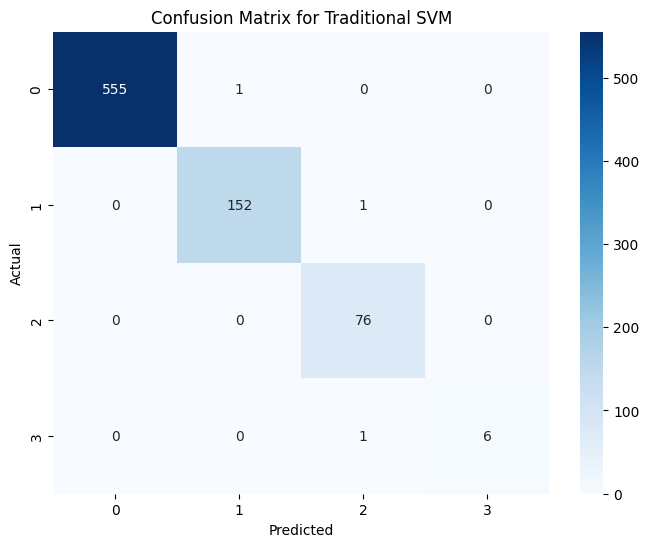

In [12]:

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Traditional SVM')
plt.show()

#### **ROC-AUC (OVR & OVO)**

In [13]:
y_prob_svc = best_model.predict_proba(X_test)
y_prob_ada = ada_model.predict_proba(X_test)

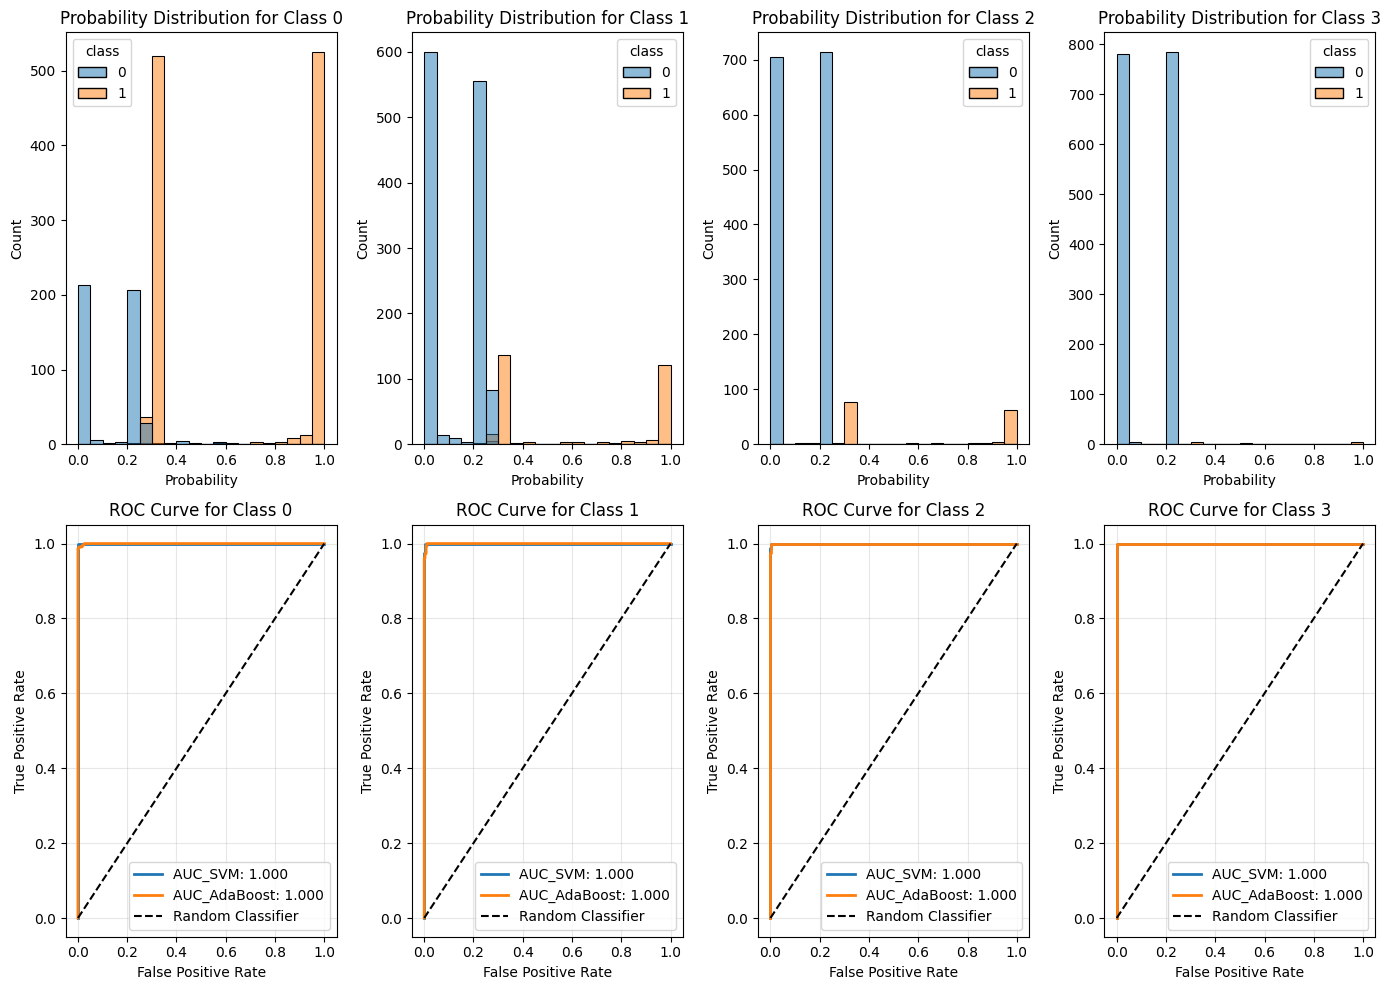

ROC-AUC Scores (One-vs-Rest):
Class 0 (SVM): 1.0000
Class 1 (SVM): 0.9999
Class 2 (SVM): 1.0000
Class 3 (SVM): 1.0000
Class 0 (AdaBoost): 0.9998
Class 1 (AdaBoost): 0.9997
Class 2 (AdaBoost): 1.0000
Class 3 (AdaBoost): 1.0000


In [14]:
#### **ROC-AUC (OVR & OVO)**

from sklearn.metrics import roc_curve, auc
import pandas as pd

class_list = [0, 1, 2, 3]

plt.figure(figsize=(14, 10))
bins = [i/20 for i in range(20)] + [1.0]
roc_auc_ovr_svm = {}
roc_auc_ovr_ada = {}

# Convert y_test to numpy array for consistency
y_test_array = np.array(y_test)

for i in range(len(class_list)):
    c = class_list[i]

    # Convert X_test (numpy array) to DataFrame
    df_aux = pd.DataFrame(X_test, columns=[f'feature_{j}' for j in range(X_test.shape[1])])

    # Fix: Use different variable name in list comprehension
    df_aux['class'] = [1 if label == c else 0 for label in y_test_array]
    df_aux['prob_svm'] = y_prob_svc[:, i]
    df_aux['prob_ada'] = y_prob_ada[:, i]
    df_aux = df_aux.reset_index(drop=True)

    # Plot histogram
    ax = plt.subplot(2, 4, i+1)
    sns.histplot(data=df_aux, x='prob_svm', hue='class', color='b', ax=ax, bins=bins)
    sns.histplot(data=df_aux, x='prob_ada', hue='class', color='r', ax=ax, bins=bins)
    ax.set_title(f'Probability Distribution for Class {c}')
    ax.set_xlabel('Probability')

    # Plot ROC curve
    ax_bottom = plt.subplot(2, 4, i+5)
    fpr_svm, tpr_svm, _ = roc_curve(df_aux['class'], df_aux['prob_svm'])
    fpr_ada, tpr_ada, _ = roc_curve(df_aux['class'], df_aux['prob_ada'])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    roc_auc_ovr_svm[c] = roc_auc_svm
    roc_auc_ovr_ada[c] = roc_auc_ada

    ax_bottom.plot(fpr_svm, tpr_svm, label=f'AUC_SVM: {roc_auc_svm:.3f}', linewidth=2)
    ax_bottom.plot(fpr_ada, tpr_ada, label=f'AUC_AdaBoost: {roc_auc_ada:.3f}', linewidth=2)
    ax_bottom.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax_bottom.set_xlabel('False Positive Rate')
    ax_bottom.set_ylabel('True Positive Rate')
    ax_bottom.set_title(f'ROC Curve for Class {c}')
    ax_bottom.legend()
    ax_bottom.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print AUC scores
print("ROC-AUC Scores (One-vs-Rest):")
for label, auc_score in roc_auc_ovr_svm.items():
    print(f"Class {label} (SVM): {auc_score:.4f}")
for label, auc_score in roc_auc_ovr_ada.items():
    print(f"Class {label} (AdaBoost): {auc_score:.4f}")

In [15]:
# make combinations of class_list for OVO
combine_labels = []
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        combine_labels.append([class_list[i], class_list[j]])
        combine_labels.append([class_list[j], class_list[i]])


In [16]:
combine_labels_1 = combine_labels[:6]
combine_labels_2 = combine_labels[6:]

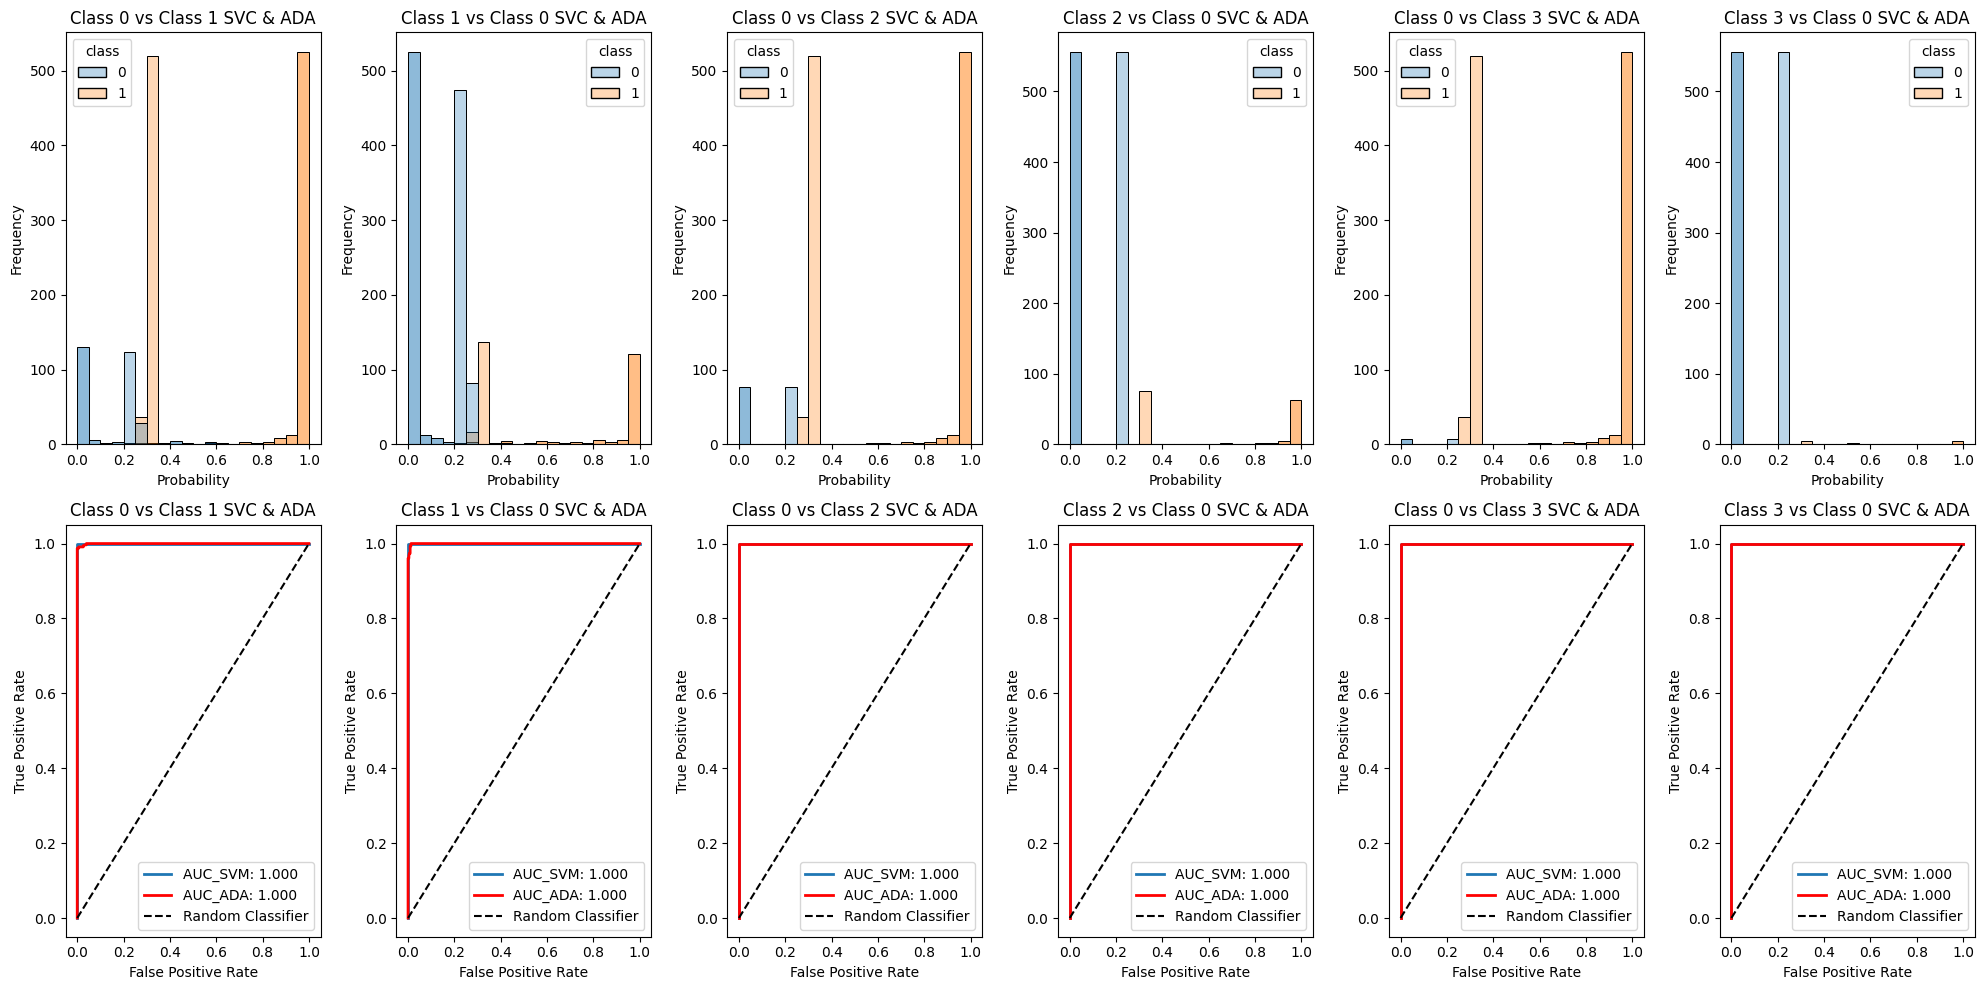

In [17]:
bins = [i/20 for i in range(20)] + [1.0]
roc_auc_ovo_svm = {}
roc_auc_ovo_ada = {}
plt.figure(figsize=(20, 10))
for i in range(len(combine_labels_1)):
    labels = combine_labels_1[i]
    df_aux = pd.DataFrame()
    c1 = labels[0]
    c2 = labels[1]
    title = f'Class {c1} vs Class {c2}'
    c1_index = class_list.index(c1)

    df_aux['class'] = y_test
    df_aux['prob_svc'] = y_prob_svc[:, c1_index]
    df_aux['prob_ada'] = y_prob_ada[:, c1_index]

    # slicing df aux just for c1 and c2
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if label == c1 else 0 for label in df_aux['class']]
    df_aux = df_aux.reset_index(drop=True)

    # plot histogram
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(data=df_aux, x='prob_svc', hue='class', color='b', ax=ax, bins=bins)
    sns.histplot(data=df_aux, x='prob_ada', hue='class', color='r', ax=ax, bins=bins, alpha=0.3)
    ax.set_title(f'{title} SVC & ADA')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

    # plot ROC curve
    ax_bottom = plt.subplot(2, 6, i+7)
    fpr_svc, tpr_svc, _ = roc_curve(df_aux['class'], df_aux['prob_svc'])
    fpr_ada, tpr_ada, _ = roc_curve(df_aux['class'], df_aux['prob_ada'])
    roc_auc_svm = auc(fpr_svc, tpr_svc)
    roc_auc_ovo_svm[title] = roc_auc_svm
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    roc_auc_ovo_ada[title] = roc_auc_ada
    ax_bottom.plot(fpr_svc, tpr_svc, label=f'AUC_SVM: {roc_auc_svm:.3f}', linewidth=2)
    ax_bottom.plot(fpr_ada, tpr_ada, label=f'AUC_ADA: {roc_auc_ada:.3f}', linewidth=2,  color='r')
    ax_bottom.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax_bottom.set_xlabel('False Positive Rate')
    ax_bottom.set_ylabel('True Positive Rate')
    ax_bottom.set_title(f'{title} SVC & ADA')
    ax_bottom.legend()

plt.tight_layout()
plt.show()

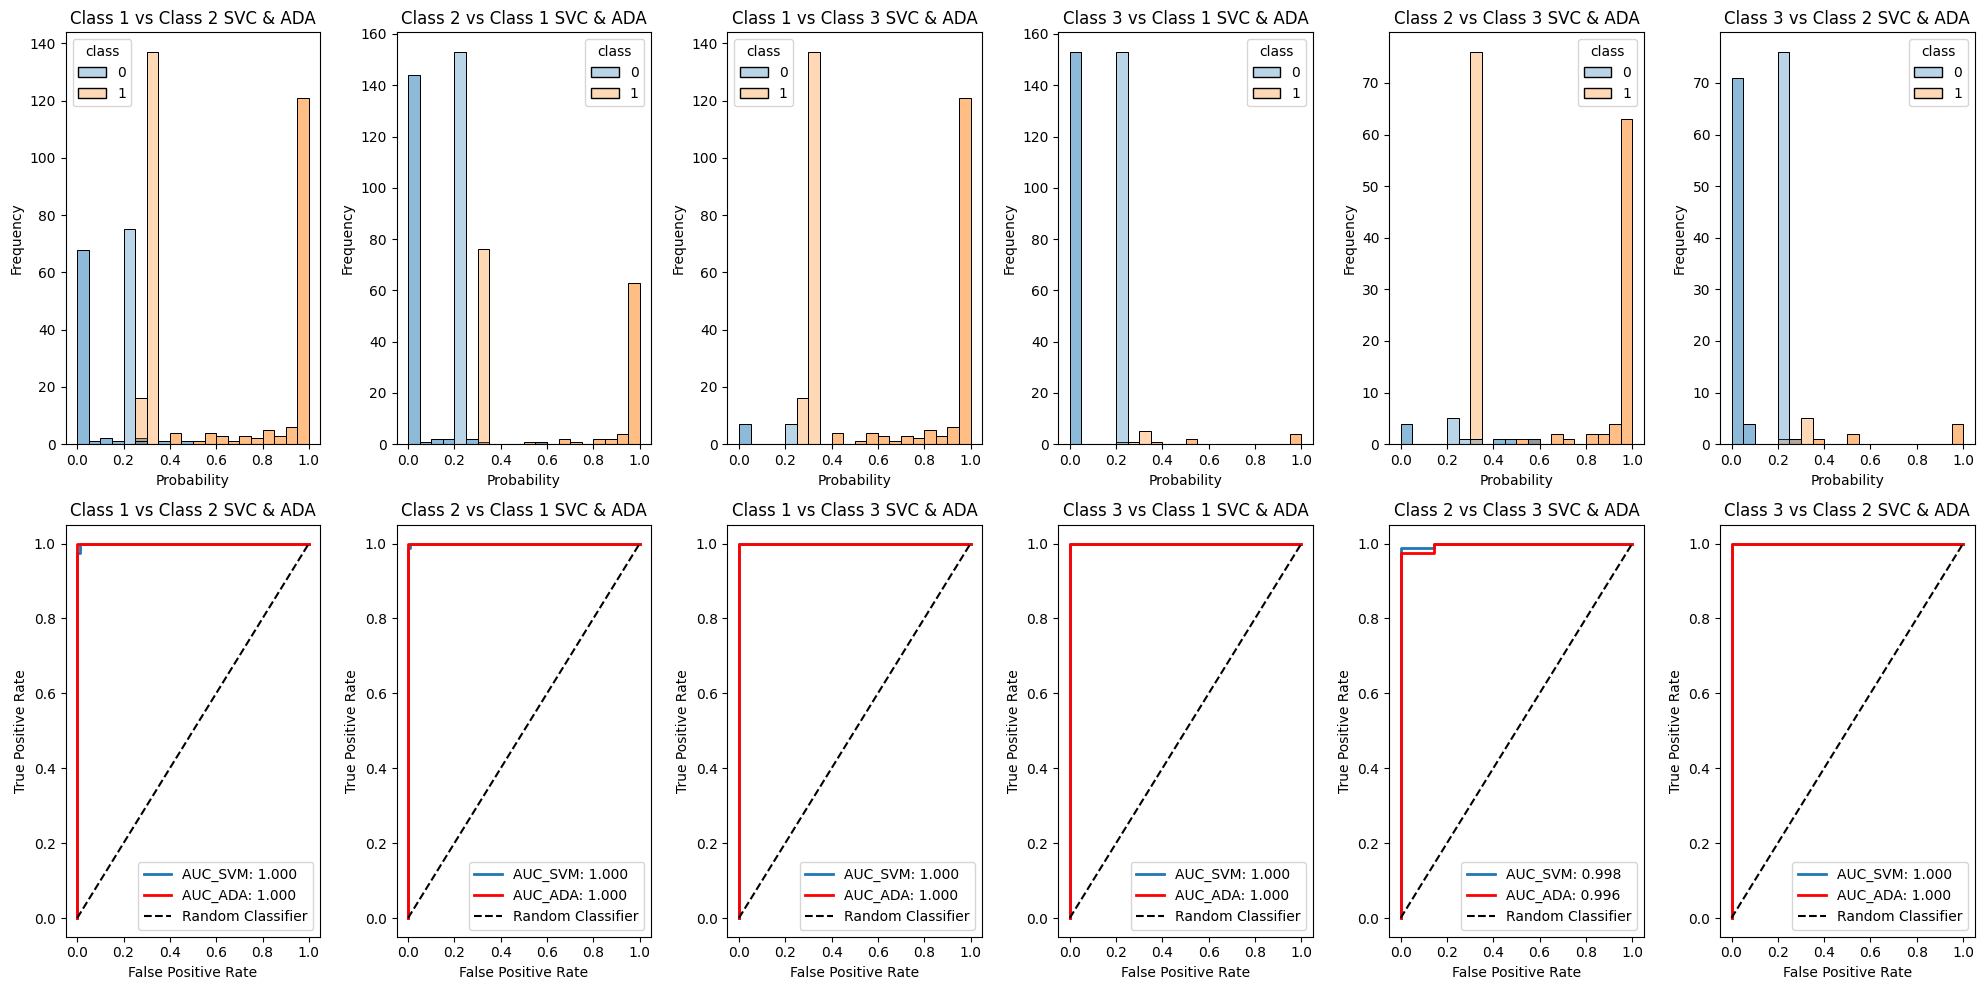

Average ROC-AUC Scores (One-vs-One) SVC:
Mean: 1.0000, Std: 0.0000
Average ROC-AUC Scores (One-vs-One) ADA:
Mean: 1.0000, Std: 0.0000


In [18]:
bins = [i/20 for i in range(20)] + [1.0]
plt.figure(figsize=(20, 10))
for i in range(len(combine_labels_2)):
    labels = combine_labels_2[i]
    df_aux = pd.DataFrame()
    c1 = labels[0]
    c2 = labels[1]
    title = f'Class {c1} vs Class {c2}'
    c1_index = class_list.index(c1)

    df_aux['class'] = y_test
    df_aux['prob_svc'] = y_prob_svc[:, c1_index]
    df_aux['prob_ada'] = y_prob_ada[:, c1_index]

    # slicing df aux just for c1 and c2
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if label == c1 else 0 for label in df_aux['class']]
    df_aux = df_aux.reset_index(drop=True)

    # plot histogram
    ax = plt.subplot(2, 6, i+1)
    sns.histplot(data=df_aux, x='prob_svc', hue='class', color='b', ax=ax, bins=bins)
    sns.histplot(data=df_aux, x='prob_ada', hue='class', color='r', ax=ax, bins=bins, alpha=0.3)
    ax.set_title(f'{title} SVC & ADA')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

    # plot ROC curve
    ax_bottom = plt.subplot(2, 6, i+7)
    fpr_svc, tpr_svc, _ = roc_curve(df_aux['class'], df_aux['prob_svc'])
    fpr_ada, tpr_ada, _ = roc_curve(df_aux['class'], df_aux['prob_ada'])
    roc_auc_svm = auc(fpr_svc, tpr_svc)
    roc_auc_ovo_svm[title] = roc_auc_svm
    roc_auc_ada = auc(fpr_ada, tpr_ada)
    roc_auc_ovo_ada[title] = roc_auc_ada
    ax_bottom.plot(fpr_svc, tpr_svc, label=f'AUC_SVM: {roc_auc_svm:.3f}', linewidth=2)
    ax_bottom.plot(fpr_ada, tpr_ada, label=f'AUC_ADA: {roc_auc_ada:.3f}', linewidth=2,  color='r')
    ax_bottom.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax_bottom.set_xlabel('False Positive Rate')
    ax_bottom.set_ylabel('True Positive Rate')
    ax_bottom.set_title(f'{title} SVC & ADA')
    ax_bottom.legend()
plt.tight_layout()
plt.show()


for key, auc_score in roc_auc_ovo_svm.items():
    dummy_list = []
    dummy_list.append(auc_score)
print("Average ROC-AUC Scores (One-vs-One) SVC:")
print(f"Mean: {np.mean(dummy_list):.4f}, Std: {np.std(dummy_list):.4f}")

for key, auc_score in roc_auc_ovo_ada.items():
    dummy_list = []
    dummy_list.append(auc_score)
print("Average ROC-AUC Scores (One-vs-One) ADA:")
print(f"Mean: {np.mean(dummy_list):.4f}, Std: {np.std(dummy_list):.4f}")


In [20]:
import joblib
# save model
joblib.dump(ada_model, 'ada_model.pkl')
# save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [21]:
joblib.dump(best_model, 'svm_model.pkl')

['svm_model.pkl']